In [1]:
cases_annotated = ['https://caselaw.nationalarchives.gov.uk/ewca/crim/2003/3',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2003/2243',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2004/2278',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2005/1983',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2006/694',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2006/1155',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2007/1530',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2008/553',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2009/1431',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2010/712',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2012/720',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2013/801',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2013/1649',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2016/52',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2017/1851',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2018/1766',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2019/362',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2020/499',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2022/83',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2023/231']

In [30]:
%matplotlib inline

from tqdm import tqdm
import requests
from requests.auth import HTTPBasicAuth
import json
from collections import defaultdict, Counter
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
import re
from copy import deepcopy
import numpy as np
import pathlib
import jsonlines
import os
from collections import defaultdict
import ast

In [3]:
API_TOKEN = '6879-Ws7xpjMTkjjUocr0Nzga0_yYkb-9sF9XmRHaKPQScCc'
USERNAME = 'stirunagari' # CharisBechan1' #'stirunagari'
GROUP_ID = 'JuDDges_Charis1' # 'JuDDges'


# Headers for the API request
headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Accept': 'application/vnd.hypothesis.v1+json',
    'Content-Type': 'application/json;charset=utf-8'
}

# Base URL for Hypothesis API
user_url = 'https://api.hypothes.is/api/profile'

In [7]:
import requests
import json
import csv

# Headers for the API request
GROUP_NAME = 'JuDDges_Vah'  # Replace with your actual group name

headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Accept': 'application/vnd.hypothesis.v1+json',
    'Content-Type': 'application/json;charset=utf-8'
}

# Base URL for Hypothesis API
user_url = 'https://api.hypothes.is/api/profile'

def get_user_information():
    try:
        response = requests.get(user_url, headers=headers)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
        
        user_info = response.json()
        print(f"User Information: {json.dumps(user_info, indent=2)}")
        return user_info
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except requests.exceptions.ConnectionError as conn_err:
        print(f"Connection error occurred: {conn_err}")
    except requests.exceptions.Timeout as timeout_err:
        print(f"Timeout error occurred: {timeout_err}")
    except requests.exceptions.RequestException as req_err:
        print(f"An error occurred: {req_err}")
    
    return None

def get_group_annotations(api_token, group_id):
    SORT_BY = 'updated'
    LIMIT = 200

    headers = {
        'Authorization': f'Bearer {api_token}',
        'Accept': 'application/vnd.hypothesis.v1+json',
        'Content-Type': 'application/json;charset=utf-8'
    }
    payload = {'group': group_id, 'sort': SORT_BY, 'limit': LIMIT}
    
    results = []
    counter = 0

    while True:
        response = requests.get('https://api.hypothes.is/api/search', params=payload, headers=headers)
        response.raise_for_status()
        data = response.json()

        annotations = data['rows']
        if not annotations:
            break

        for anno in annotations:
            counter += 1
            results.append(extract_annotations(anno))

        if counter >= data['total']:
            break

        payload['search_after'] = annotations[-1]['updated']

    assert data['total'] == counter, f"Expected {data['total']} annotations, but extracted {counter}"
    return results

def extract_annotations(annotation):
    """Extract annotation information from each Hypothesis annotation"""
    try:
        anno = {
            'source': annotation['target'][0]['source'],
            'exact': None,
            'comment': annotation.get('text', ''),
            'tags': annotation.get('tags', [])
        }

        target = annotation['target'][0]
        if 'selector' in target:
            for selector in target['selector']:
                if selector['type'] == 'TextQuoteSelector':
                    anno['exact'] = selector['exact']

    except Exception as e:
        print(f"Error extracting annotation: {e}")
        print(annotation)
        raise
    return anno

def save_annotations_to_csv(annotations, filename='annotations.csv'):
    keys = ['source', 'exact', 'comment', 'tags']
    with open(filename, 'w', newline='', encoding='utf-8') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(annotations)

# Fetch user information
user_information = get_user_information()

if user_information:
    groups = user_information['groups']
    all_annotations = []

    # Fetch annotations for the specified group
    for group in groups:
        if group['name'] == GROUP_NAME:
            group_id = group['id']
            print(f"Fetching annotations for group: {group['name']} ({group_id})")
            annotations = get_group_annotations(api_token=API_TOKEN, group_id=group_id)
            all_annotations.extend(annotations)
            break

    print(f"Total annotations fetched: {len(all_annotations)}")

    # Save annotations to CSV
    save_annotations_to_csv(all_annotations)
    print("Annotations saved to annotations.csv")
else:
    print("Failed to retrieve user information.")


User Information: {
  "userid": "acct:stirunagari@hypothes.is",
  "authority": "hypothes.is",
  "groups": [
    {
      "name": "Public",
      "id": "__world__",
      "public": true
    },
    {
      "name": "JuDDges",
      "id": "1yeVRNek",
      "public": false,
      "url": "https://api.hypothes.is/groups/1yeVRNek/juddges"
    },
    {
      "name": "JuDDges_Charis1",
      "id": "ebKd44jY",
      "public": false,
      "url": "https://api.hypothes.is/groups/ebKd44jY/juddges-charis1"
    },
    {
      "name": "JuDDGes_Intra_Charis",
      "id": "rKV4Ev5p",
      "public": false,
      "url": "https://api.hypothes.is/groups/rKV4Ev5p/juddges-intra-charis"
    },
    {
      "name": "JuDDges_Intra_Vili",
      "id": "Qb9zgyQY",
      "public": false,
      "url": "https://api.hypothes.is/groups/Qb9zgyQY/juddges-intra-vili"
    },
    {
      "name": "JuDDges_Vah",
      "id": "BjRM6pBd",
      "public": false,
      "url": "https://api.hypothes.is/groups/BjRM6pBd/juddges-vah"
    

In [35]:
# Read the annotations CSV file
filename = 'annotations.csv'
annotations_df = pd.read_csv(filename)


In [44]:
def convert_to_case(url):
    parts = url.split('/')
    year = parts[-2]
    case_number = parts[-1]
    return f"[{year}] EWCA Crim {case_number}"

# Apply the function to the 'source' column to create the 'Case' column
annotations_df['Case'] = annotations_df['source'].apply(convert_to_case)
annotations_df['tags'] = annotations_df['tags'].apply(ast.literal_eval)

In [45]:
annotations_df

,source,exact,comment,tags,Case
0,https://caselaw.nationalarchives.gov.uk/ewca/c...,doorman,Employed,[OffJobOffence],[2016] EWCA Crim 52
1,https://caselaw.nationalarchives.gov.uk/ewca/c...,Charlton asked her and KP,Acquaintance,[OffVicRelation],[2016] EWCA Crim 52
2,https://caselaw.nationalarchives.gov.uk/ewca/c...,Jane R gave a total of four statements.,Eyewitness,[ProsEvidTypeTrial],[2016] EWCA Crim 52
3,https://caselaw.nationalarchives.gov.uk/ewca/c...,Elizabeth Williams made four statements.,Eyewitness,[ProsEvidTypeTrial],[2016] EWCA Crim 52
4,https://caselaw.nationalarchives.gov.uk/ewca/c...,verdict in respect of the first Appellant is u...,Verdict is unsafe,[AppealGround],[2016] EWCA Crim 52
...,...,...,...,...,...
607,https://caselaw.nationalarchives.gov.uk/ewca/c...,Crown Court at Truro,Crown Court,[ConvCourtType],[2020] EWCA Crim 499
608,https://caselaw.nationalarchives.gov.uk/ewca/c...,Crown Court at Truro,Crown Court at Truro,[ConvCourtName],[2020] EWCA Crim 499
609,https://caselaw.nationalarchives.gov.uk/ewca/c...,July 2018,July 2018,[ConvictPleaDate],[2020] EWCA Crim 499
610,https://caselaw.nationalarchives.gov.uk/ewca/c...,jury,Yes,[Jurytrial],[2020] EWCA Crim 499


In [57]:
set(cases_annotated) - set(annotations_df['source'].unique().tolist())

{'https://caselaw.nationalarchives.gov.uk/ewca/crim/2003/2243'}

In [14]:
# Read the annotations CSV file
filename = 'data/Curation_in_detail - Vili.csv'
curation_sheet_df = pd.read_csv(filename)
curation_sheet_df = curation_sheet_df.dropna(axis=1, how='all')

In [15]:
curation_sheet_df



,Coding,Description,tag_name,[2003] EWCA Crim 3,[2003] EWCA Crim 2243,[2004] EWCA Crim 2278,[2005] EWCA Crim 1983,[2006] EWCA Crim 694,[2006] EWCA Crim 1155,[2007] EWCA Crim 1530,...,[2012] EWCA Crim 720,[2013] EWCA Crim 801,[2013] EWCA Crim 1649,[2016] EWCA Crim 52,[2017] EWCA Crim 1851,[2018] EWCA Crim 1766,[2019] EWCA Crim 362,[2020] EWCA Crim 499,[2022] EWCA Crim 83,[2023] EWCA Crim 231
0,ConvCourtType Court Type where Offender was Co...,Magistrates’ court/Crown court,ConvCourtType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ConvCourtName(s) Court Name(s) where Offender ...,Text (List all courts if convicted/pled guilty...,ConvCourtName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ConvictPleaDate Conviction/Guilty Plea Date(s),Numeric (List all),ConvictPleaDate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Was there a Jurytrial?\nIf YES, JuryDecisionType","Yes/No/Don’t know\nIf YES, Unanimous/Majority/...",Jurytrial,Don't know,NaN,NaN,Don't know,NaN,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,Don't know,NaN,Don't know,No
4,NaN,NaN,JuryDecisionType,NaN,NaN,NaN,NaN,NaN,Don't know,NaN,...,Don't know,Don't know,NaN,Don't know,Don't know,NaN,NaN,NaN,NaN,NaN
5,ConvictOffence What Offence(s) was Offender Co...,Text (List all),ConvictOffence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,AcquitOffence What Offence(s) was Offender Acq...,N/A OR Text (List all),AcquitOffence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Did Offender Confess/Plead Guilty? \nIf YES, a...","Yes/No\nIf YES, in police presence/at first co...",Confess/Plead,Don't know,NaN,No,Yes,No,No,NaN,...,NaN,NaN,No,NaN,No,No,NaN,No,Yes,NaN
8,NaN,NaN,PleaPoint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Don't know,NaN
9,What was the RemandDecision for Offender?\nIf ...,Unconditional Bail/Conditional Bail/ Remanded ...,RemandDecision,Don't know,NaN,NaN,NaN,Don'know,Don't know,NaN,...,NaN,NaN,NaN,Don't know,Don't know,NaN,NaN,Don’t know,Don't know,Don't know


In [41]:
annotations_df[annotations_df['Case']=='[2004] EWCA Crim 2278']

,source,exact,comment,tags,Case
489,https://caselaw.nationalarchives.gov.uk/ewca/c...,"In those circumstances, we do not consider tha...",No ground for appeal,['ReasonDismiss'],[2004] EWCA Crim 2278
490,https://caselaw.nationalarchives.gov.uk/ewca/c...,"Accordingly, we dismiss these appeals",Dismissed,['AppealOutcome'],[2004] EWCA Crim 2278
491,https://caselaw.nationalarchives.gov.uk/ewca/c...,gave expert evidence to this extent,Expert testimony,['ProsEvidTypeTrial'],[2004] EWCA Crim 2278
492,https://caselaw.nationalarchives.gov.uk/ewca/c...,It is submitted that this particular Act sets ...,Form of indictment,['AppealGround'],[2004] EWCA Crim 2278
493,https://caselaw.nationalarchives.gov.uk/ewca/c...,They appeal against conviction with leave of t...,Appeal against conviction with leave of the si...,['AppealAgainst'],[2004] EWCA Crim 2278
494,https://caselaw.nationalarchives.gov.uk/ewca/c...,MARK WAKEFIELD AND MARK ANDREW PURSEGLOVE,2,['CoDefAccNum'],[2004] EWCA Crim 2278
495,https://caselaw.nationalarchives.gov.uk/ewca/c...,MARK WAKEFIELD AND MARK ANDREW PURSEGLOVE,1,['CoDefAccNum'],[2004] EWCA Crim 2278
496,https://caselaw.nationalarchives.gov.uk/ewca/c...,MARK ANDREW PURSEGLOVE,NaN,['Appellant'],[2004] EWCA Crim 2278
497,https://caselaw.nationalarchives.gov.uk/ewca/c...,MARK WAKEFIELD,NaN,['Appellant'],[2004] EWCA Crim 2278
498,https://caselaw.nationalarchives.gov.uk/ewca/c...,believed that trading was permissible,Was not aware that trading the items was illegal,['DefEvidTypeTrial'],[2004] EWCA Crim 2278


In [49]:
# Loop through each unique case in annotations_df
for case in annotations_df['Case'].unique():
    # Filter the rows for the current case in annotations_df
    case_rows = annotations_df[annotations_df['Case'] == case]
    
    # Loop through each row for the current case
    for _, row in case_rows.iterrows():
        tags = row['tags']
        exact = row['exact']
        comment = row['comment']
        
        # Loop through each tag
        for tag in tags:
            # Find the matching row in curation_sheet_df
            tag_row = curation_sheet_df[curation_sheet_df['tag_name'] == tag]
            
            if not tag_row.empty:
                tag_index = tag_row.index[0]
                
                # Update the curation_sheet_df if the cell is blank
                if pd.isna(curation_sheet_df.at[tag_index, case]):
                    curation_sheet_df.at[tag_index, case] = f"Exact: {exact}\n\n, Comment: {comment}"


In [50]:
tags

['JuryDecisionType']

In [51]:
curation_sheet_df

,Coding,Description,tag_name,[2003] EWCA Crim 3,[2003] EWCA Crim 2243,[2004] EWCA Crim 2278,[2005] EWCA Crim 1983,[2006] EWCA Crim 694,[2006] EWCA Crim 1155,[2007] EWCA Crim 1530,...,[2012] EWCA Crim 720,[2013] EWCA Crim 801,[2013] EWCA Crim 1649,[2016] EWCA Crim 52,[2017] EWCA Crim 1851,[2018] EWCA Crim 1766,[2019] EWCA Crim 362,[2020] EWCA Crim 499,[2022] EWCA Crim 83,[2023] EWCA Crim 231
0,ConvCourtType Court Type where Offender was Co...,Magistrates’ court/Crown court,ConvCourtType,"Exact: TAUNTON CROWN COURT, Comment: Crown Court",NaN,"Exact: Crown Court, Comment: nan","Exact: Crown Court, Comment: nan","Exact: Crown Court, Comment: nan","Exact: Crown Court, Comment: nan","Exact: Crown Court, Comment: nan",...,"Exact: Crown Court, Comment: nan","Exact: Central Criminal Court, Comment: Crown ...","Exact: Crown Court, Comment: nan","Exact: Crown Court, Comment: nan","Exact: Crown Court, Comment: nan","Exact: Magistrates' Court, Comment: nan","Exact: Crown Court, Comment: nan","Exact: Crown Court at Truro, Comment: Crown Court","Exact: Crown Court, Comment: nan","Exact: Crown Court, Comment: nan"
1,ConvCourtName(s) Court Name(s) where Offender ...,Text (List all courts if convicted/pled guilty...,ConvCourtName,"Exact: TAUNTON CROWN COURT, Comment: Taunton C...",NaN,"Exact: Crown Court at Reading, Comment: nan","Exact: Crown Court at Teeside, Comment: nan","Exact: Crown Court at Liverpool, Comment: nan","Exact: Birmingham Crown Court, Comment: nan","Exact: Crown Court at Liverpool, Comment: nan",...,"Exact: Peterborough Crown Court, Comment: nan","Exact: Central Criminal Court, Comment: nan","Exact: Crown Court sitting in Manchester., Com...","Exact: Cardiff Crown Court, Comment: nan","Exact: Crown Court at Warwick, Comment: nan","Exact: Bristol Magistrates' Court, Comment: nan","Exact: Crown Court at Manchester, Comment: nan","Exact: Crown Court at Truro, Comment: Crown Co...","Exact: Crown Court at Chelmsford, Comment: nan","Exact: Crown Court at Liverpool, Comment: nan"
2,ConvictPleaDate Conviction/Guilty Plea Date(s),Numeric (List all),ConvictPleaDate,"Exact: 20.12.02, Comment: 20.12.02",NaN,"Exact: 6th June 2003, Comment: 06.06.2003","Exact: 18 February 2005, Comment: 18.02.2005","Exact: 9th September 2005, Comment: 09.09.2005","Exact: 18 March 2005, Comment: 18.05.2005","Exact: 27th February 2006, Comment: 27.02.2006",...,NaN,"Exact: 8 June 2012, Comment: 08.07.2012","Exact: 9th September 2011, Comment: 09.11.2011","Exact: 26 February 1991, Comment: 26.02.1991","Exact: 17th February 2017, Comment: 17.02.2017","Exact: 16 March 2018, Comment: 16.03.2018",NaN,"Exact: July 2018, Comment: July 2018","Exact: 16 January 2020, Comment: 16.01.2020","Exact: 6th February 2015, Comment: 06/02/2015"
3,"Was there a Jurytrial?\nIf YES, JuryDecisionType","Yes/No/Don’t know\nIf YES, Unanimous/Majority/...",Jurytrial,Don't know,NaN,Exact: jury proceeded to consider the matter o...,Don't know,"Exact: jury, Comment: Yes","Exact: jury, Comment: Yes",No,...,"Exact: jury, Comment: Yes","Exact: jury, Comment: Yes","Exact: jury, Comment: Yes","Exact: jury, Comment: Yes","Exact: jury, Comment: Yes",NaN,Don't know,"Exact: jury, Comment: Yes",Don't know,No
4,NaN,NaN,JuryDecisionType,NaN,NaN,Exact: jury convicted the appellants of the co...,NaN,NaN,Don't know,NaN,...,Don't know,Don't know,"Exact: majority, Comment: nan",Don't know,Don't know,NaN,NaN,Exact: jury returned a not guilty verdict agai...,NaN,NaN
5,ConvictOffence What Offence(s) was Offender Co...,Text (List all),ConvictOffence,"Exact: indecent assault, Comment: nan",NaN,Exact: six counts of unauthorised use of trade...,Exact: making and distributing indecent photog...,Exact: offence of inflicting grievous bodily h...,Exact: two of the three counts of attempt murd...,Exact: to wounding with intent contrary to sec...,...,"Exact: three offences of rape, two indecent as...","Exact: alleged murder, Comment: nan","Exact: soliciting to murder, Comment: nan","Exact: convicted of the murder, Comm

# Automate across all users and file_names (use this script)

In [32]:
import requests
import json
import csv

API_TOKEN = '6879-Ws7xpjMTkjjUocr0Nzga0_yYkb-9sF9XmRHaKPQScCc'


# Headers for the API request
GROUP_NAMES = ['JuDDges_Vah', 'JuDDges', 'JuDDges_Charis1']  # Replace with your actual group names

headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Accept': 'application/vnd.hypothesis.v1+json',
    'Content-Type': 'application/json;charset=utf-8'
}

# Base URL for Hypothesis API
user_url = 'https://api.hypothes.is/api/profile'

def get_user_information():
    try:
        response = requests.get(user_url, headers=headers)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
        
        user_info = response.json()
        print(f"User Information: {json.dumps(user_info, indent=2)}")
        return user_info
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except requests.exceptions.ConnectionError as conn_err:
        print(f"Connection error occurred: {conn_err}")
    except requests.exceptions.Timeout as timeout_err:
        print(f"Timeout error occurred: {timeout_err}")
    except requests.exceptions.RequestException as req_err:
        print(f"An error occurred: {req_err}")
    
    return None

def get_group_annotations(api_token, group_id):
    SORT_BY = 'updated'
    LIMIT = 200

    headers = {
        'Authorization': f'Bearer {api_token}',
        'Accept': 'application/vnd.hypothesis.v1+json',
        'Content-Type': 'application/json;charset=utf-8'
    }
    payload = {'group': group_id, 'sort': SORT_BY, 'limit': LIMIT}
    
    results = []
    counter = 0

    while True:
        response = requests.get('https://api.hypothes.is/api/search', params=payload, headers=headers)
        response.raise_for_status()
        data = response.json()

        annotations = data['rows']
        if not annotations:
            break

        for anno in annotations:
            counter += 1
            results.append(extract_annotations(anno))

        if counter >= data['total']:
            break

        payload['search_after'] = annotations[-1]['updated']

    assert data['total'] == counter, f"Expected {data['total']} annotations, but extracted {counter}"
    return results

def extract_annotations(annotation):
    """Extract annotation information from each Hypothesis annotation"""
    try:
        anno = {
            'user': annotation['user'],
            'source': annotation['target'][0]['source'],
            'exact': None,
            'comment': annotation.get('text', ''),
            'tags': annotation.get('tags', [])
        }

        target = annotation['target'][0]
        if 'selector' in target:
            for selector in target['selector']:
                if selector['type'] == 'TextQuoteSelector':
                    anno['exact'] = selector['exact']

    except Exception as e:
        print(f"Error extracting annotation: {e}")
        print(annotation)
        raise
    return anno

def save_annotations_to_csv(annotations, filename):
    keys = ['user', 'source', 'exact', 'comment', 'tags']
    with open(filename, 'w', newline='', encoding='utf-8') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(annotations)

# Fetch user information
user_information = get_user_information()

if user_information:
    groups = user_information['groups']
    all_annotations = []
    group_ids = [group['id'] for group in groups if group['name'] in GROUP_NAMES]

    # Fetch annotations for each group
    for group_id in group_ids:
        print(f"Fetching annotations for group ID: {group_id}")
        annotations = get_group_annotations(api_token=API_TOKEN, group_id=group_id)
        all_annotations.extend(annotations)

    print(f"Total annotations fetched: {len(all_annotations)}")

    # Group annotations by user
    annotations_by_user = {}
    for annotation in all_annotations:
        user = annotation['user']
        if user not in annotations_by_user:
            annotations_by_user[user] = []
        annotations_by_user[user].append(annotation)

    # Save annotations for each user to separate CSV files
    for user, user_annotations in annotations_by_user.items():
        filename = f"{user.replace(':', '_')}_annotations.csv"
        save_annotations_to_csv(user_annotations, filename)
        print(f"Annotations for user {user} saved to {filename}")

else:
    print("Failed to retrieve user information.")


User Information: {
  "userid": "acct:stirunagari@hypothes.is",
  "authority": "hypothes.is",
  "groups": [
    {
      "name": "Public",
      "id": "__world__",
      "public": true
    },
    {
      "name": "JuDDges",
      "id": "1yeVRNek",
      "public": false,
      "url": "https://api.hypothes.is/groups/1yeVRNek/juddges"
    },
    {
      "name": "JuDDges_Charis1",
      "id": "ebKd44jY",
      "public": false,
      "url": "https://api.hypothes.is/groups/ebKd44jY/juddges-charis1"
    },
    {
      "name": "JuDDGes_Intra_Charis",
      "id": "rKV4Ev5p",
      "public": false,
      "url": "https://api.hypothes.is/groups/rKV4Ev5p/juddges-intra-charis"
    },
    {
      "name": "JuDDges_Intra_Vili",
      "id": "Qb9zgyQY",
      "public": false,
      "url": "https://api.hypothes.is/groups/Qb9zgyQY/juddges-intra-vili"
    },
    {
      "name": "JuDDges_Vah",
      "id": "BjRM6pBd",
      "public": false,
      "url": "https://api.hypothes.is/groups/BjRM6pBd/juddges-vah"
    

In [70]:
# import pandas as pd
# import ast

# # List of annotation CSV files
# filenames_annoated = ['acct_CharisBechan1@hypothes.is_annotations.csv', 'acct_vah@hypothes.is_annotations.csv']

# # List of curation sheet CSV files
# filename_curation_in_detail = ['data/Curation_in_detail - Vili.csv', 'data/Curation_in_detail - Charis.csv']

# def convert_to_case(url):
#     parts = url.split('/')
#     year = parts[-2]
#     case_number = parts[-1]
#     return f"[{year}] EWCA Crim {case_number}"

# for annotation_file, curation_file in zip(filenames_annoated, filename_curation_in_detail):
#     # Read the annotations CSV file
#     annotations_df = pd.read_csv(annotation_file)
#     annotations_df['Case'] = annotations_df['source'].apply(convert_to_case)
#     annotations_df['tags'] = annotations_df['tags'].apply(ast.literal_eval)

#     # Read the curation sheet CSV file
#     curation_sheet_df = pd.read_csv(curation_file)
#     curation_sheet_df = curation_sheet_df.dropna(axis=1, how='all')

#     # Loop through each unique case in annotations_df
#     for case in annotations_df['Case'].unique():
#         # Filter the rows for the current case in annotations_df
#         case_rows = annotations_df[annotations_df['Case'] == case]
        
#         # Loop through each row for the current case
#         for _, row in case_rows.iterrows():
#             tags = row['tags']
#             exact = row['exact']
#             comment = row['comment']
            
#             # Loop through each tag
#             for tag in tags:
#                 # Find the matching row in curation_sheet_df
#                 tag_row = curation_sheet_df[curation_sheet_df['tag_name'] == tag]
                
#                 if not tag_row.empty:
#                     tag_index = tag_row.index[0]
                    
#                     # Update the curation_sheet_df if the cell is blank
#                     if pd.isna(curation_sheet_df.at[tag_index, case]):
#                         curation_sheet_df.at[tag_index, case] = f"Exact: {exact}\n\n, Comment: {comment}"

#     # Save the updated curation sheet
#     output_filename = f"updated_{curation_file.split('/')[-1]}"
#     curation_sheet_df.to_csv(output_filename, index=False)
#     print(f"Updated curation sheet saved to {output_filename}")



In [34]:
import pandas as pd
import ast

# List of annotation CSV files
filenames_annoated = ['acct_CharisBechan1@hypothes.is_annotations.csv', 'acct_vah@hypothes.is_annotations.csv']

# List of curation sheet CSV files
filename_curation_in_detail = ['data/Curation_in_detail - Vili.csv', 'data/Curation_in_detail - Charis.csv']

def convert_to_case(url):
    parts = url.split('/')
    year = parts[-2]
    case_number = parts[-1]
    return f"[{year}] EWCA Crim {case_number}"

def drop_empty_columns(df):
    # Drop columns that contain only 'NA' or empty strings
    return df.loc[:, (df != 'NA').any(axis=0) & (df != '').any(axis=0)]

for annotation_file, curation_file in zip(filenames_annoated, filename_curation_in_detail):
    # Read the annotations CSV file
    annotations_df = pd.read_csv(annotation_file, na_filter=False)
    annotations_df['Case'] = annotations_df['source'].apply(convert_to_case)
    annotations_df['tags'] = annotations_df['tags'].apply(ast.literal_eval)

    # Read the curation sheet CSV file
    curation_sheet_df = pd.read_csv(curation_file, na_filter=False)
    curation_sheet_df = drop_empty_columns(curation_sheet_df)

    # Loop through each unique case in annotations_df
    for case in annotations_df['Case'].unique():
        # Filter the rows for the current case in annotations_df
        case_rows = annotations_df[annotations_df['Case'] == case]
        
        # Loop through each row for the current case
        for _, row in case_rows.iterrows():
            tags = row['tags']
            exact = row['exact']
            comment = row['comment']
            
            # Loop through each tag
            for tag in tags:
                # Find the matching row in curation_sheet_df
                tag_row = curation_sheet_df[curation_sheet_df['tag_name'] == tag]
                
                if not tag_row.empty:
                    tag_index = tag_row.index[0]
                    
                    # Update the curation_sheet_df if the cell is empty or contains an empty string
                    if curation_sheet_df.at[tag_index, case] == '' or pd.isna(curation_sheet_df.at[tag_index, case]):
                        curation_sheet_df.at[tag_index, case] = f"Exact: {exact};\n\n Comment: {comment}"

    # Save the updated curation sheet
    output_filename = f"updated_{curation_file.split('/')[-1]}"
    curation_sheet_df.to_csv(output_filename, index=False)
    print(f"Updated curation sheet saved to {output_filename}")


Updated curation sheet saved to updated_Curation_in_detail - Vili.csv
Updated curation sheet saved to updated_Curation_in_detail - Charis.csv


In [73]:
tags

['JuryDecisionType']

In [59]:
# set(cases_annotated) - set(annotations_df['source'].unique().tolist())

set()

In [60]:
# len(annotations_df['source'].unique().tolist())

20

# Annotations analysis

In [36]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Load the updated curation sheets
file1 = 'updated_Curation_in_detail - Vili.csv'
file2 = 'updated_Curation_in_detail - Charis.csv'

df1 = pd.read_csv(file1, na_filter=False)
df2 = pd.read_csv(file2, na_filter=False)

# Ensure the dataframes have the same columns
common_columns = df1.columns.intersection(df2.columns)
df1 = df1[common_columns]
df2 = df2[common_columns]

# Initialize lists to hold comparison results
tag_names = []
agreement = []
partial_agreement = []

def extract_content(text):
    if 'Exact:' in text and 'Comment:' in text:
        parts = text.split('Comment:')
        exact = parts[0].replace('Exact:', '').strip()
        comment = parts[1].strip()
        return exact, comment
    return '', ''

# Compare tags in both dataframes
for tag in df1['tag_name']:
    if tag in df2['tag_name'].values:
        tag_names.append(tag)
        
        # Extract the columns with case annotations
        case_columns = common_columns.drop(['tag_name'])
        
        # Count matches and partial matches
        total_cases = len(case_columns)
        exact_matches = 0
        partial_matches = 0
        
        for case in case_columns:
            val1 = df1.loc[df1['tag_name'] == tag, case].values[0]
            val2 = df2.loc[df2['tag_name'] == tag, case].values[0]
            
            exact1, comment1 = extract_content(val1)
            exact2, comment2 = extract_content(val2)
            
            if val1 == val2:  # Exact match, including 'NA' and empty
                exact_matches += 1
            elif (exact1 in exact2 or exact2 in exact1 or comment1 in comment2 or comment2 in comment1) and (val1 != '' and val2 != ''):  # Partial match
                partial_matches += 1
        
        agreement.append(exact_matches / total_cases)
        partial_agreement.append((exact_matches + partial_matches) / total_cases)

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Tag Name': tag_names,
    'Percentage Agreed': agreement,
    'Partial Agreement': partial_agreement
})

# Display the results
print(comparison_df)

                    Tag Name  Percentage Agreed  Partial Agreement
0              ConvCourtType           0.090909           0.818182
1              ConvCourtName           0.500000           0.863636
2            ConvictPleaDate           0.090909           0.636364
3                  Jurytrial           0.181818           0.863636
4           JuryDecisionType           0.409091           0.454545
5             ConvictOffence           0.090909           0.772727
6              AcquitOffence           0.181818           0.772727
7              Confess/Plead           0.409091           0.772727
8                  PleaPoint           0.227273           0.363636
9             RemandDecision           0.272727           0.545455
10         RemandCustodyTime           0.272727           0.272727
11             SentCourtType           0.136364           0.818182
12             SentCourtName           0.318182           0.681818
13                  Sentence           0.136364           0.77

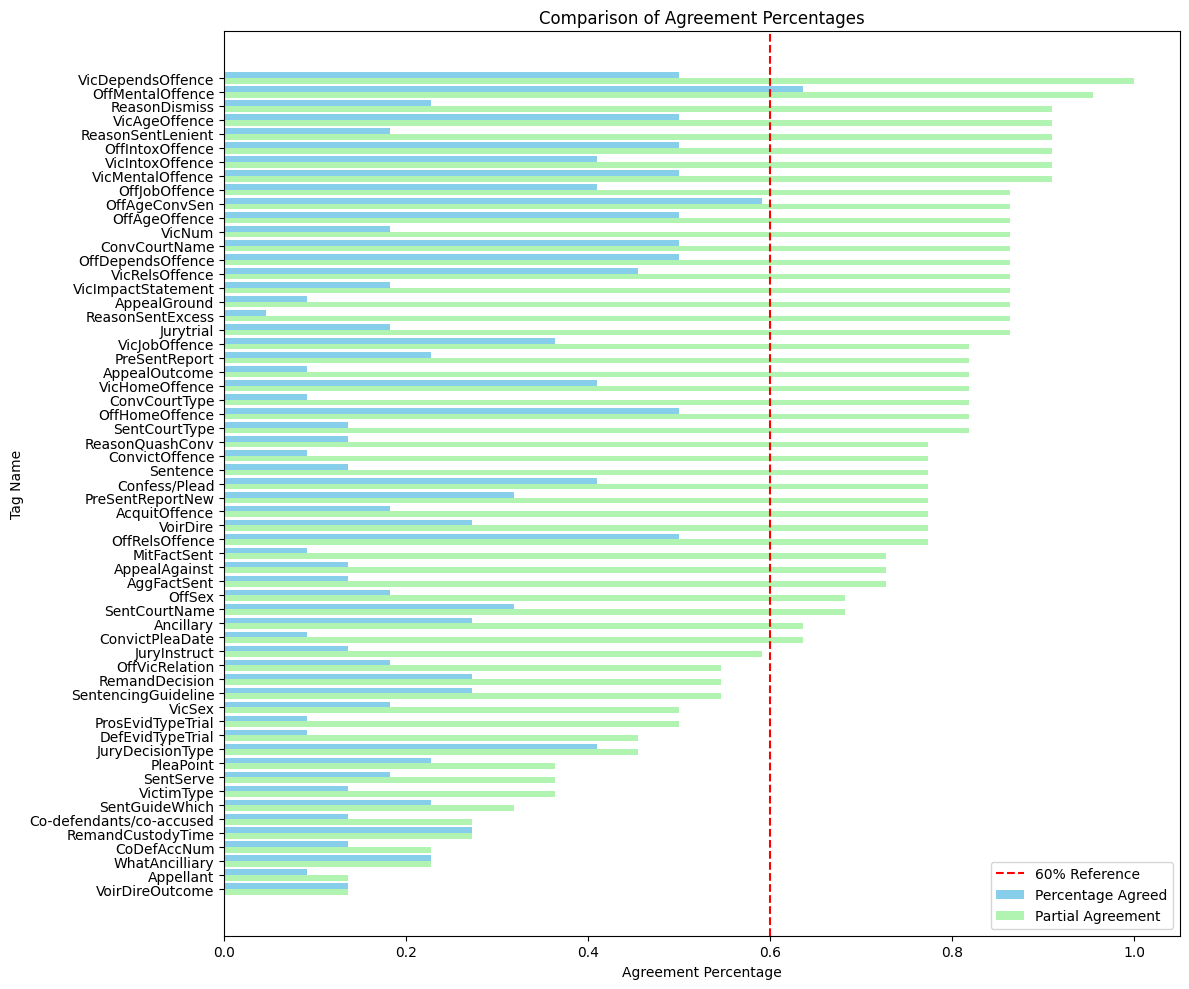

In [46]:
# Save the plot as a PNG file
plt.figure(figsize=(12, 10))
bar_width = 0.4
index = range(len(sorted_df))

plt.barh(index, sorted_df['Percentage Agreed'], bar_width, color='skyblue', label='Percentage Agreed')
plt.barh([i + bar_width for i in index], sorted_df['Partial Agreement'], bar_width, color='lightgreen', alpha=0.7, label='Partial Agreement')

# Adding space between variable names
plt.yticks([i + bar_width / 2 for i in index], sorted_df['Tag Name'])
plt.xlabel('Agreement Percentage')
plt.ylabel('Tag Name')
plt.title('Comparison of Agreement Percentages')

# Adding a reference line at 60%
plt.axvline(x=0.6, color='red', linestyle='--', label='60% Reference')

plt.legend()
plt.gca().invert_yaxis()  # To have the highest values on top
plt.tight_layout()

# Save the plot to a file
plt.savefig('comparison_agreement_percentages.png')
plt.show()


In [50]:
import pandas as pd

# Load the updated curation dataframes
charis_df = pd.read_csv('updated_Curation_in_detail - Charis.csv', na_filter=False)
vili_df = pd.read_csv('updated_Curation_in_detail - Vili.csv', na_filter=False)

def adjust_values(text):
    if 'Exact:' in text and 'Comment:' in text:
        exact_part = text.split('Exact: ')[1].split('Comment:')[0].strip()
        comment_part = text.split('Comment: ')[1].strip()
        if comment_part in ['-', '', ' ']:
            return exact_part
        else:
            return comment_part
    elif 'Exact:' in text:
        return text.split('Exact: ')[1].strip()
    elif 'Comment:' in text:
        return text.split('Comment: ')[1].strip()
    else:
        return text

# Apply the adjustment function to each dataframe
for col in charis_df.columns[3:]:
    charis_df[col] = charis_df[col].apply(adjust_values)

for col in vili_df.columns[3:]:
    vili_df[col] = vili_df[col].apply(adjust_values)

# Rename columns to distinguish between Charis and Vili
charis_columns = {col: f"{col} (Charis)" for col in charis_df.columns[3:]}
vili_columns = {col: f"{col} (Vili)" for col in vili_df.columns[3:]}

charis_df.rename(columns=charis_columns, inplace=True)
vili_df.rename(columns=vili_columns, inplace=True)

# Merge the dataframes on the first three columns
merged_df = pd.merge(charis_df.iloc[:, :3], charis_df.iloc[:, 3:], left_index=True, right_index=True)
merged_df = pd.merge(merged_df, vili_df.iloc[:, 3:], left_index=True, right_index=True)

# Ensure Charis columns follow corresponding Vili columns
merged_columns = list(merged_df.columns[:3])  # Keep the first three columns
for col in charis_df.columns[3:]:
    if col in merged_df.columns:
        vili_col = col.replace('(Charis)', '(Vili)')
        if vili_col in merged_df.columns:
            merged_columns.append(col)
            merged_columns.append(vili_col)
        else:
            merged_columns.append(col)

merged_df = merged_df[merged_columns]

# Save the merged dataframe to a CSV file
merged_df.to_csv('merged_curation_comparison.csv', index=False)
print("Merged curation dataframe saved to merged_curation_comparison.csv")


Merged curation dataframe saved to merged_curation_comparison.csv


In [ ]:
# Sort the dataframe by Percentage Agreed in descending order
# sorted_df = comparison_df.sort_values(by='Partial Agreement', ascending=False)

# # Plot the sorted dataframe
# plt.figure(figsize=(10, 8))
# plt.barh(sorted_df['Tag Name'], sorted_df['Percentage Agreed'], color='skyblue', label='Percentage Agreed')
# plt.barh(sorted_df['Tag Name'], sorted_df['Partial Agreement'], color='lightgreen', alpha=0.7, label='Partial Agreement')
# plt.xlabel('Agreement Percentage')
# plt.ylabel('Tag Name')
# plt.title('Comparison of Agreement Percentages')
# plt.legend()
# plt.gca().invert_yaxis()  # To have the highest values on top
# plt.show()